/tmp/ipykernel_97844/2085368606.py:42: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  Xorig = imageio.imread('image.jpg', pilmode='L')


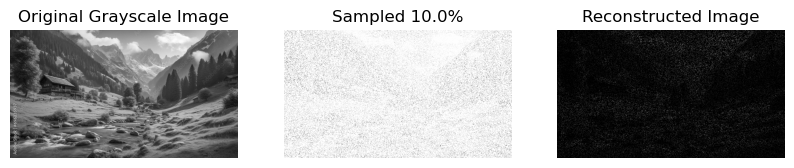

In [ ]:
import numpy as np
import imageio
import scipy.fftpack as spfft
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define Discrete Cosine Transform (DCT) and its inverse
def dct2(x):
    return spfft.dct(spfft.dct(x, axis=0, norm='ortho'), axis=1, norm='ortho')

def idct2(x):
    return spfft.idct(spfft.idct(x, axis=0, norm='ortho'), axis=1, norm='ortho')

# Define the evaluation function for L-BFGS-B
def evaluate_flattened(x):
    """Objective function for L1-optimization."""

    # Expand x column-first
    x2 = x.reshape((nx, ny)).T

    # Ax is the inverse 2D DCT of x2
    Ax2 = idct2(x2)

    # Stack columns and extract samples
    Ax = Ax2.T.flat[ri].reshape(b.shape)

    # Calculate residual Ax-b and its 2-norm squared
    Axb = Ax - b
    fx = np.sum(Axb**2)

    # Project residual onto a blank image
    Axb2 = np.zeros(x2.shape)
    Axb2.T.flat[ri] = Axb  # Fill columns-first

    # Compute gradient (A'(Ax-b) is the 2D DCT of Axb2)
    AtAxb2 = 2 * dct2(Axb2)
    AtAxb = AtAxb2.T.reshape(x.shape)  # Stack columns

    return fx, AtAxb

# Read the image as grayscale (1-channel)
Xorig = imageio.imread('image.jpg', pilmode='L')
ny, nx = Xorig.shape  # Only 2D (since grayscale)

# Fractions of the scaled image to randomly sample at
sample_sizes = (0.1, 0.01)

# Initialize output images and masks
Z = [np.zeros(Xorig.shape, dtype='uint8') for _ in sample_sizes]
masks = [np.zeros(Xorig.shape, dtype='uint8') for _ in sample_sizes]

# Loop through each sample size
for i, s in enumerate(sample_sizes):

    # Create random sampling index vector
    k = round(nx * ny * s)
    ri = np.random.choice(nx * ny, k, replace=False)  # Random sample indices

    # Extract channel (already grayscale, so no loop needed)
    X = Xorig.squeeze()
    
    # Create mask image for visualization
    Xm = 255 * np.ones(X.shape)
    Xm.T.flat[ri] = X.T.flat[ri]
    masks[i] = Xm
    
    # Take random samples and store in a vector b
    b = X.T.flat[ri].astype(float)

    # Perform L1 minimization using L-BFGS-B
    result = minimize(
        evaluate_flattened, 
        np.zeros(nx * ny), 
        method="L-BFGS-B", 
        jac=True  # Use gradient
    )

    # Transform the output back into the spatial domain
    Xat = result.x.reshape(nx, ny).T  # Stack columns
    Xa = idct2(Xat)

    # 🔥 Normalize Xa to the range [0, 255]
    Xa = np.clip((Xa - Xa.min()) / (Xa.max() - Xa.min()) * 255, 0, 255) 

    Z[i] = Xa.astype('uint8')

# Display original and reconstructed images
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(Xorig, cmap='gray')
plt.title('Original Grayscale Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(masks[0], cmap='gray')
plt.title(f'Sampled {sample_sizes[0]*100:.1f}%')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(Z[0], cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

plt.show()
